In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
train_path = "/kaggle/input/emotions-dataset-for-nlp/train.txt"

In [3]:
df = pd.read_table(train_path, sep=";", header=None)

In [4]:
df.head()

,0,1
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
df.columns = ['text', 'emotion']

In [6]:
df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     16000 non-null  object
 1   emotion  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [8]:
df.emotion.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

<Axes: xlabel='count', ylabel='emotion'>

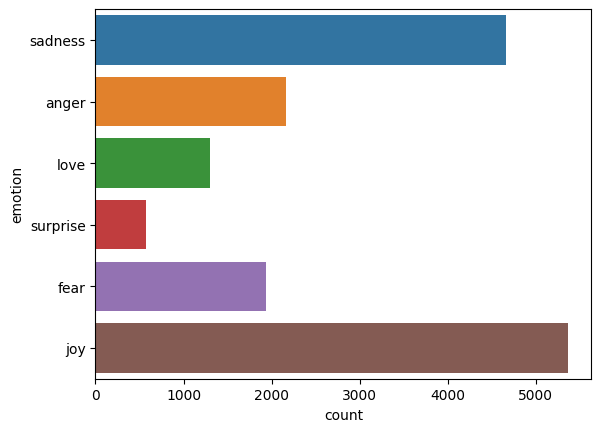

In [9]:
sns.countplot(y=df.emotion)

In [10]:
df.groupby('emotion').agg('count')

,text
emotion,
anger,2159
fear,1937
joy,5362
love,1304
sadness,4666
surprise,572


In [11]:
from imblearn.over_sampling import RandomOverSampler

In [12]:
x, y = RandomOverSampler(sampling_strategy={
    'anger': 3500, 'love': 3500, 'surprise': 3500, 'fear': 3500, 'sadness': 4666, 'joy': 5362
}).fit_resample(df.text.to_numpy().reshape(-1, 1), df.emotion)

<Axes: xlabel='count', ylabel='emotion'>

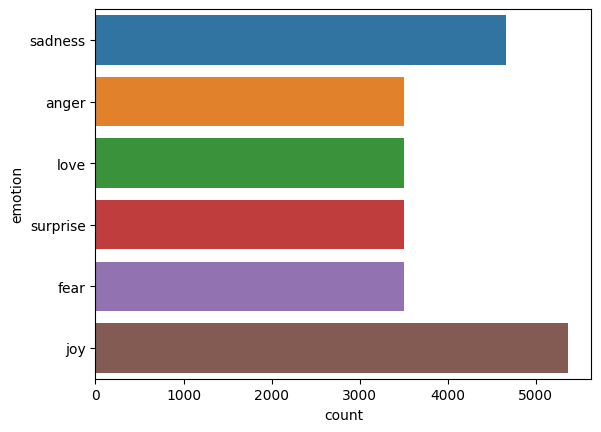

In [13]:
sns.countplot(y=y)

In [14]:
df = pd.DataFrame({
    'text': x.reshape(-1),
    'emotion': y,
})

In [15]:
df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24028 entries, 0 to 24027
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     24028 non-null  object
 1   emotion  24028 non-null  object
dtypes: object(2)
memory usage: 375.6+ KB


In [17]:
import tensorflow as tf

2024-05-27 10:38:04.930594: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 10:38:04.930721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 10:38:05.094999: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [18]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [19]:
BUFFER_SIZE = 10000
BATCH_SIZE = 16

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X = df.text.to_numpy()
Y = np.expand_dims(df.emotion.astype('category').cat.codes.to_numpy(), axis=1)

In [22]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y)

In [23]:
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((18021,), (18021, 1), (6007,), (6007, 1))

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices((xtrain, ytrain)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((xtest, ytest)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [25]:
VOCAB_SIZE=1000

In [26]:
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

In [27]:
encoder.adapt(train_dataset.map(lambda text, label: text))

In [28]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'feel', 'and', 'to', 'the', 'a', 'feeling',
       'that', 'of', 'my', 'in', 'it', 'like', 'so', 'im', 'for', 'was',
       'me'], dtype='<U13')

In [29]:
encoder("my name is tanmay").numpy()

array([ 11, 671,  22,   1])

In [30]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6),
])

In [31]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, True]


In [32]:
sample_text = 'The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.'
predictions = model.predict(np.array([sample_text], dtype='object'))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[-0.00379184  0.00081271  0.00264279  0.0022931   0.01539659 -0.00574231]


In [33]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding], dtype='object'))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[-0.00379184  0.00081271  0.00264279  0.0022931   0.0153966  -0.00574231]


In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (1, None)              │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (1, None, 64)          │        64,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (1, None, 128)         │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (1, 64)                │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 32)                │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 6)                 │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,542 (677.90 KB)

 Trainable params: 173,542 (677.90 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=18)

Epoch 1/18
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 81s 64ms/step - accuracy: 0.4428 - loss: 1.3415 - val_accuracy: 0.8438 - val_loss: 0.4745
Epoch 2/18
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 81s 63ms/step - accuracy: 0.8603 - loss: 0.4158 - val_accuracy: 0.8680 - val_loss: 0.3695
Epoch 3/18
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 71s 63ms/step - accuracy: 0.8841 - loss: 0.3218 - val_accuracy: 0.8645 - val_loss: 0.3468
Epoch 4/18
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 72s 63ms/step - accuracy: 0.8965 - loss: 0.2713 - val_accuracy: 0.8741 - val_loss: 0.3414
Epoch 5/18
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 71s 63ms/step - accuracy: 0.9003 - loss: 0.2612 - val_accuracy: 0.8810 - val_loss: 0.3396
Epoch 6/18
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 81s 62ms/step - accuracy: 0.9147 - loss: 0.2221 - val_accuracy: 0.8810 - val_loss: 0.3371
Epoch 7/18
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 71s 63ms/step - accuracy: 0.9205 - loss: 0.2068 - val_accuracy: 0.8861 - val_loss: 0.3281
Epoch 8/18
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 71s 63ms/step - accuracy: 0.9321 -

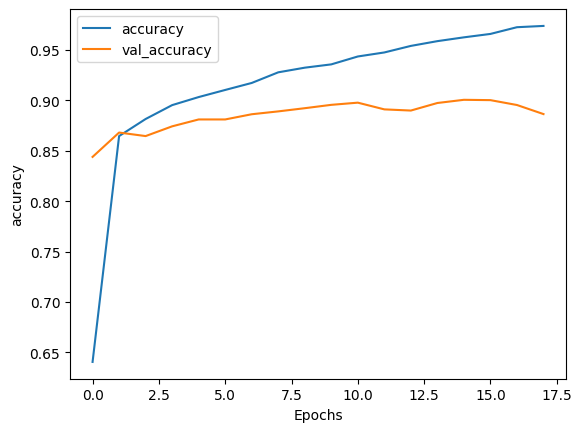

In [37]:
plot_graphs(history, 'accuracy')

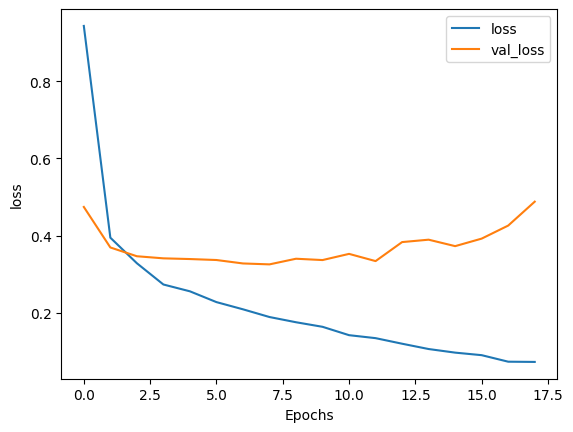

In [38]:
plot_graphs(history, 'loss')

In [39]:
data = {
    'emotion': df.emotion,
    'cat': np.squeeze(Y)
}

mapping = {}

def get_values(x):
    mapping[x['cat']] = x['emotion']

pd.DataFrame(data).drop_duplicates().apply(get_values, axis=1)
print("Made maps")

Made maps


In [40]:
def get_pred(x):
    if x == "":
        print("EMPTY!")
        return
    
    return mapping[np.argmax(model.predict(np.array([x], dtype='object')))]

In [41]:
get_pred('i am happy')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step


'joy'